## Time Series Project 

### By Carolyn Davis 

### Germain Cohort

------------------------------------------------------------------------------------------------------------------

- The goal of this mini-project is to practice what you have learned at each stage of the pipeline
    throughout the time series module. 
    
- You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com.

- You will select one location, could be a city or a state or something relatively similar in size
    and analyze the patterns in temperature over time. 
    
- You will then model those patterns to forecast temperature into the future (how far is up to you,
    but should be something meaningful).

## Project Planning:

1.) Pick a city / state from data set
2.) Acquire the data
3.) Explore the unclean data to determine Data Prep Need To
4.) Prepare / clean / tidy the data for splitting / exploration
5.) Pick a reasonable splitting point and split into train / test datasets
6.) Explore the train dataset
7.) Look at Daily / Weekly / Monthly / Quarterly / Yearly trends / cycles
8.) Visualize changes over time
9.) Visualize a seasonal cyclefe
10.) Show lag plots / Auto-correlation / Decomposition / Mas
11.) Build at least 3 Models (Simple Average, Moving Average, Holt's Linear Trend, Change timeframe based-on)
12.) Evaluate Models, adjust hyperparameters and pick best model to evaluate on test
13.) Conclusions / Takeaways / Next Steps

In [1]:
#Imports utilized for this project:
#Imports utilized for this stage:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from dateutil import parser
# for tsa 
import statsmodels.api as sm


plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)



## Data Acquisition

In [3]:
def get_glob_temp():
    '''
    Acquires global land temperatures by major city from Kaggle
    CSV 
    '''
    df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
    
    #pulls just the temp data for just London
    df = df.loc[df['City'] == 'London']
    df = df.reset_index(drop=True)
    
    return df

In [4]:
df = get_glob_temp()

## Data Preparation

In [5]:
def bad_format(data):
    
    to_fix = data[data["dt"].str.len() < 10].reset_index(drop=True)
    gucci = data[data["dt"].str.len() == 10].reset_index(drop=True)
    return to_fix, gucci

to_fix, gucci = bad_format(df)

In [6]:
def century_flag(data):
    data["flag"] = np.where(data.index < 1200, "1900", "2000")
    return data

to_fix = century_flag(to_fix)

In [7]:
def date_fix(col):
    new_col = [parser.parse(item) for item in col]
    new_col = [item.date() for item in new_col]
    new_col = pd.Series(new_col)
    new_col.index=col.index
    
    return new_col

to_fix["dt"] = date_fix(to_fix["dt"])
gucci["dt"] = date_fix(gucci["dt"])

In [8]:
def final_fix(data):
    
    data = data.reset_index(drop=True)
    
    def splitter(date, flag):
        year, month, day = str(date).split("-")
        if flag == "1900" and int(year) >= 2000:
            year = str(int(year) - 100)
        month = str(month)
        day = str(day)
        fixed = f"{year}-{month}-{day}"
        return fixed
    
    dates = pd.Series([parser.parse(splitter(day, flag)).date() for day, flag in zip(data["dt"], data["flag"])], 
                      name="dt")
    
    
    data["dt"] = dates
    
    data = data.drop(["flag"], axis=1)
    return data.sort_values(by="dt").dropna().reset_index(drop=True)

to_fix = final_fix(to_fix)

In [9]:
f = pd.concat([gucci, to_fix], axis=0)
df = df.sort_values(by="dt")
df = df.dropna().reset_index(drop=True)
df = df.set_index("dt")


In [10]:
def prep_glob_temp(df):
        #drops irrelevant columns 
    df = df.drop(columns=(['City', 'Country', 'Latitude', 'Longitude']))
    
    
    #renames the columns for easier readibility
    df = df.rename(columns={'dt': 'date','AverageTemperature':'avg_temp','AverageTemperatureUncertainty':'avg_temp_uncertainty'})
    return df

df = prep_glob_temp(df)

In [11]:
def add_year_col(df):
    df['year'] = [str(day).split('-')[0] for day in df.index]
    return df

df = add_year_col(df)

<AxesSubplot:xlabel='year'>

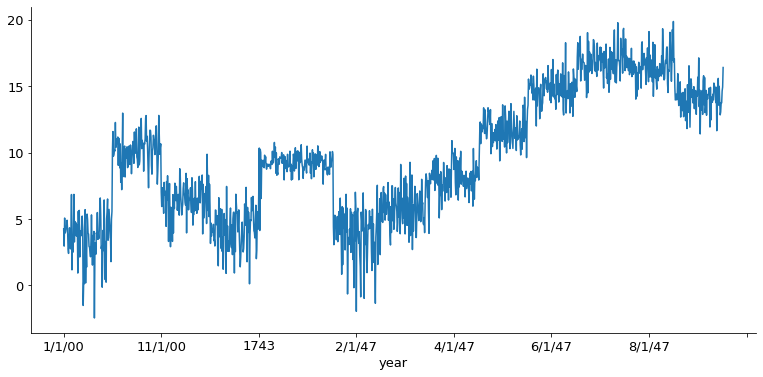

In [12]:
#how does average temperature change over the years?
df.groupby('year').avg_temp.mean().plot()



<AxesSubplot:>

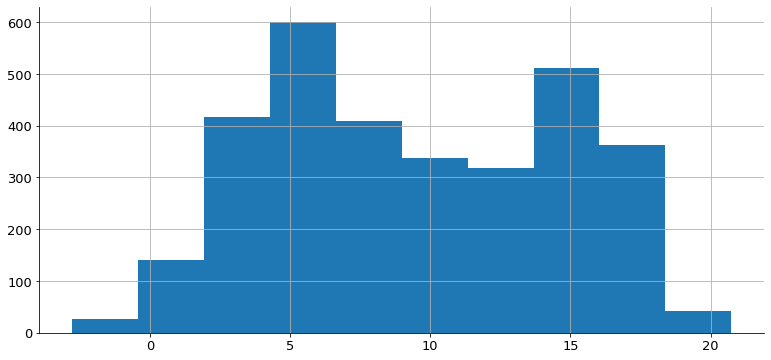

In [13]:
#average temp distribution
df.avg_temp.hist()


<AxesSubplot:xlabel='year'>

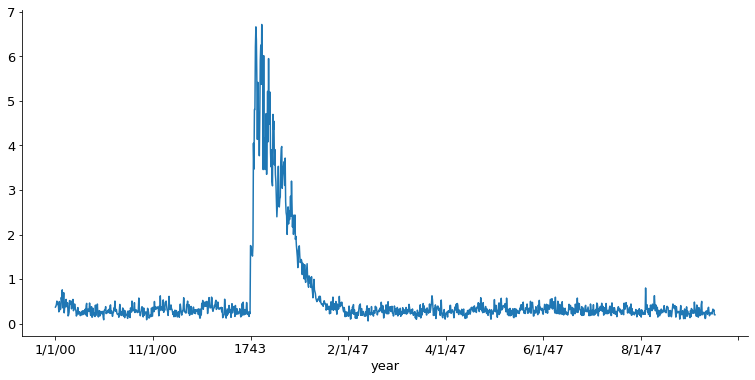

In [14]:
# how does the unvertainty change over all of these years?
df.groupby('year').avg_temp_uncertainty.mean().plot()



In [15]:
#Only going to look at date, and average temperature
df1 = df[['avg_temp']]

#50% of our data goes to train
train_size = int(len(df1)*0.5)


#30% goes to validate
validate_size = int(len(df1)*0.3)


#test gets 20% aka what is left over
test_size = int(len(df1)-train_size - validate_size)


#establishing that the end of the validate set is the length of train size and validate size combined
validate_end_index = train_size + validate_size


In [16]:
#train
train = df1[:train_size]
#validate
validate = df1[train_size:validate_end_index]
#test
test = df1[validate_end_index:]




# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df1))
#output: True



True


In [17]:
train2 = train.copy()
train2.index = pd.DatetimeIndex(train.index)

validate2 = validate.copy()
validate2.index = pd.DatetimeIndex(validate.index)


test2 = test.copy()
test2.index = pd.DatetimeIndex(test.index)


## Exploration

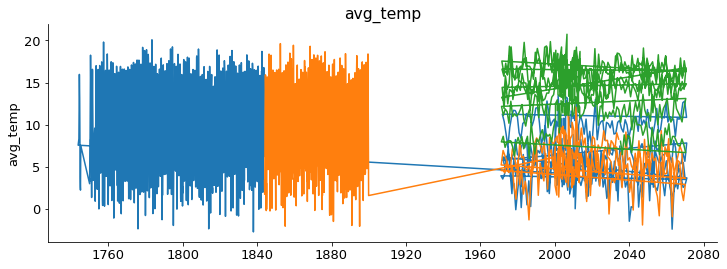

In [18]:
#Visualizing the split data:
for col in train2.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train2[col])
    plt.plot(validate2[col])
    plt.plot(test2[col])
    
    plt.ylabel(col)
    plt.title(col)
    

In [19]:
train2 = pd.DataFrame(train2["avg_temp"].resample("Y").mean().dropna())

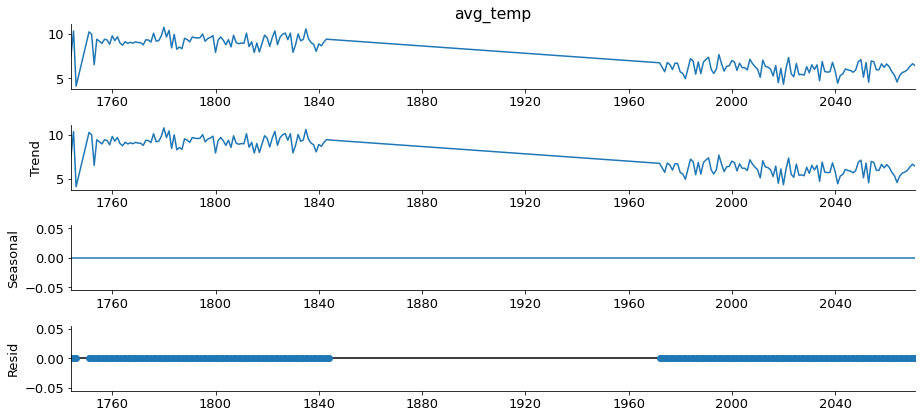

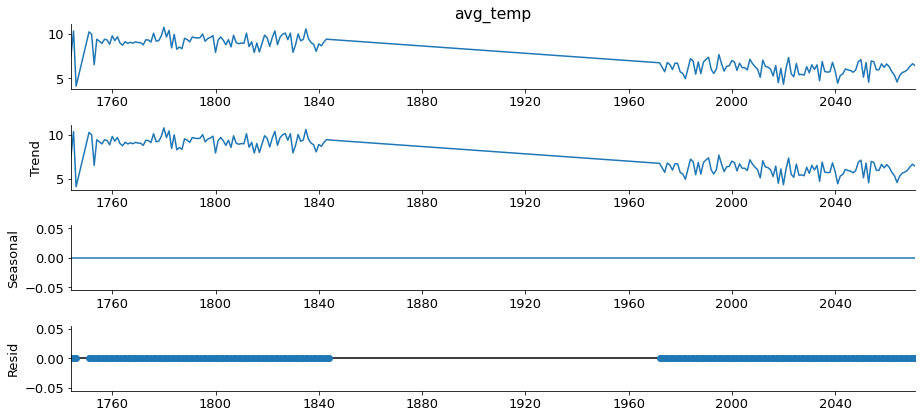

In [20]:
#seasonal decomposition - 1 year
seasonal = sm.tsa.seasonal_decompose(train2["avg_temp"], model="additive", period=1)
seasonal.plot()


<AxesSubplot:xlabel='dt'>

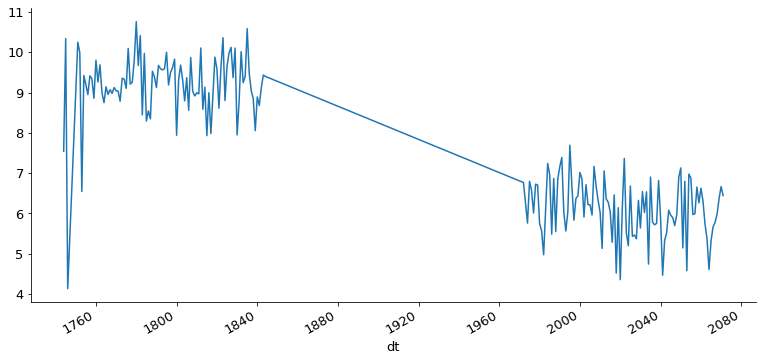

In [21]:
#further exploration with average temperature
y = train2.avg_temp
#let's take a look at our training data
y.plot()
#TAKEAWAY:
    #avg temop seems pretty constistent

<AxesSubplot:xlabel='dt'>

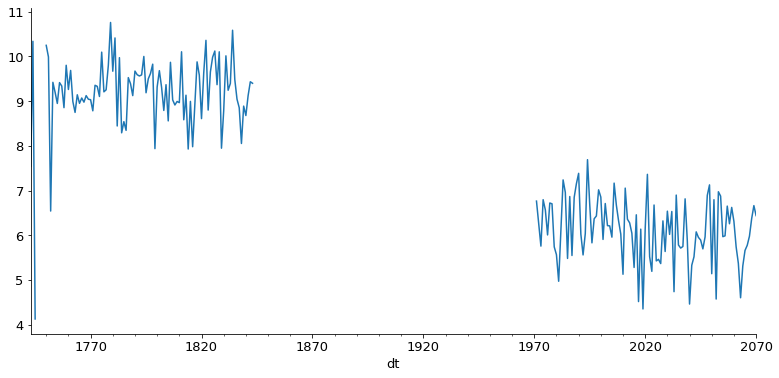

In [22]:
y.resample('1Y').mean().plot()
#Takeaway:
    #Still fairly consistent apart from the initial drop

<AxesSubplot:xlabel='dt'>

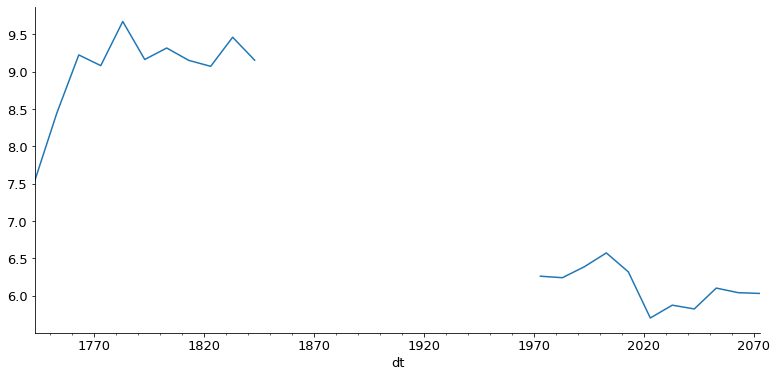

In [23]:
y.resample('10Y').mean().plot()
    #Over decades appears fairly consistent avg temp range 
    
    

<AxesSubplot:xlabel='dt'>

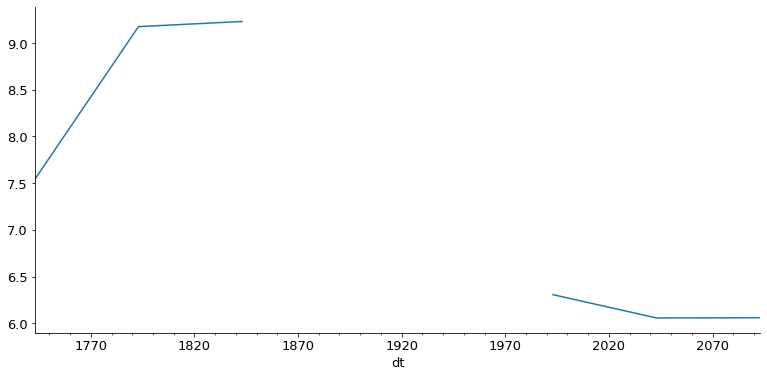

In [24]:
y.resample('50Y').mean().plot()

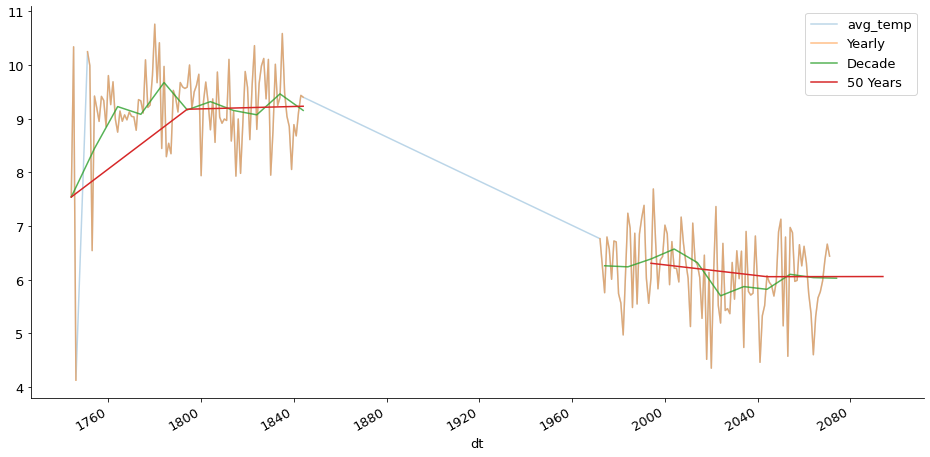

In [25]:
#average temperatures across various time periods
plt.figure(figsize=(16,8))
ax = y.plot(alpha=.3)
y.resample('1Y').mean().plot(ax=ax, alpha=.5, label='Yearly')
y.resample('10Y').mean().plot(ax=ax, alpha=.8, label='Decade')
y.resample('50Y').mean().plot(ax=ax, label='50 Years')
ax.legend()
plt.show()

[Text(0.5, 1.0, 'Average Temperature Over Year'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Temperature')]

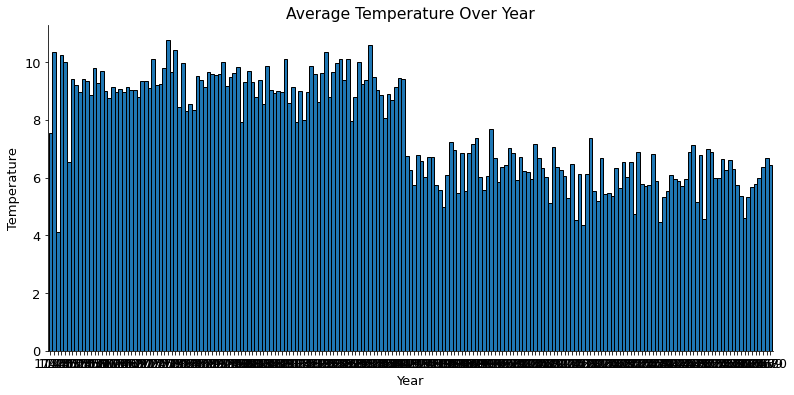

In [26]:
y.index = pd.to_datetime(y.index)

#average temperatures by year but in a bar chart.
ax = y.groupby(y.index.year).mean().plot.bar(width=1,ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature Over Year', xlabel='Year',ylabel='Temperature')


In [ ]:
#                   LAG: Future Performance

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

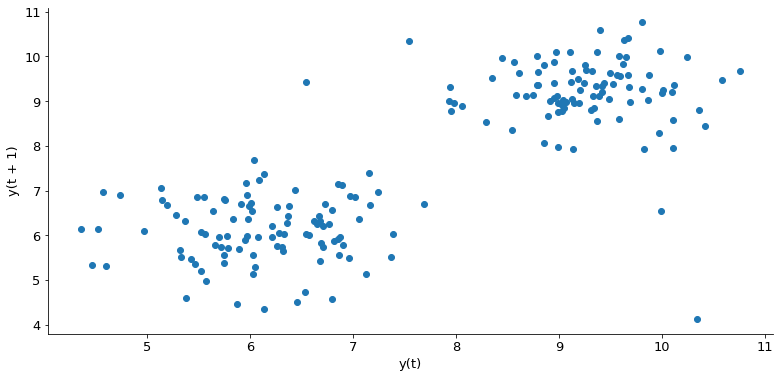

In [27]:
# How does it project 1 month out?
pd.plotting.lag_plot(y.resample('Y').mean(), 1)





<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

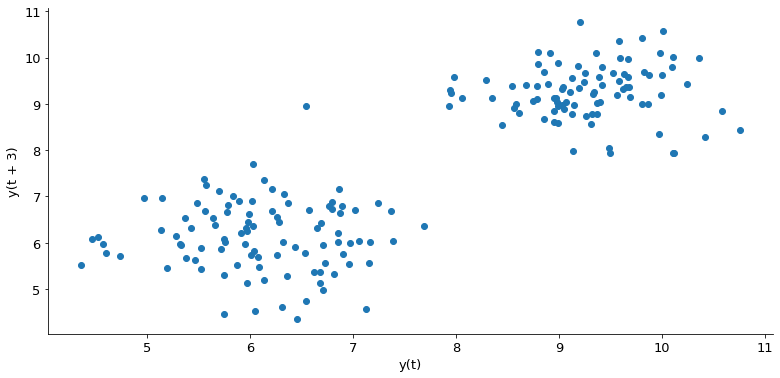

In [28]:
# How does it project 3 years out?
pd.plotting.lag_plot(y.resample('Y').mean(), 3)



<AxesSubplot:xlabel='y(t)', ylabel='y(t + 6)'>

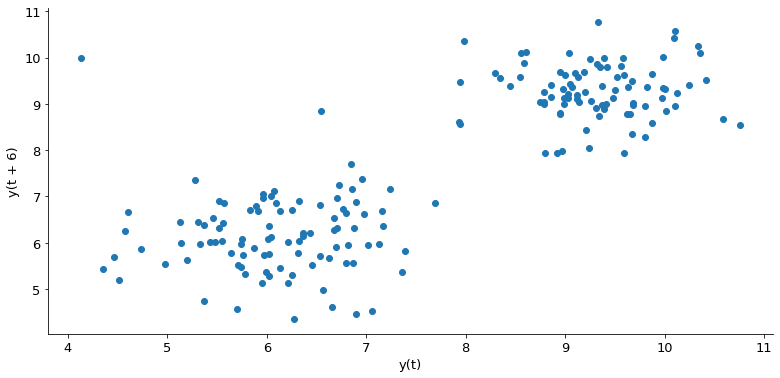

In [29]:

# How does it project 6 years out?
pd.plotting.lag_plot(y.resample('Y').mean(), 6)



<AxesSubplot:xlabel='y(t)', ylabel='y(t + 10)'>

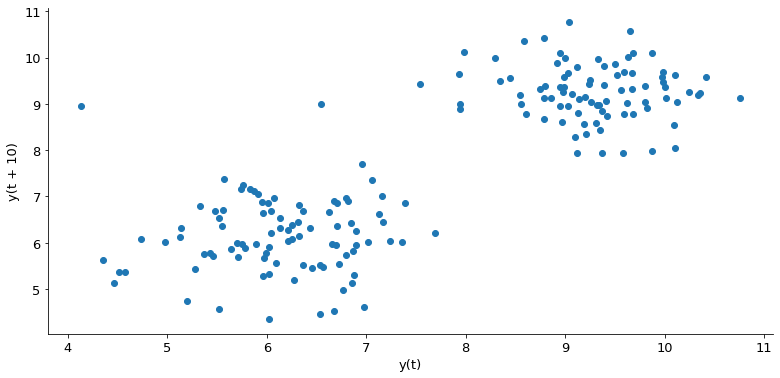

In [30]:

# How does it project 10 years out?
pd.plotting.lag_plot(y.resample('Y').mean(), 10)



In [31]:
def correlation(y, lag):
    return pd.concat([y, y.shift(lag)], axis=1).dropna().corr().iloc[0, 1]


autocorr = pd.Series({lag: correlation(y.resample('Y').mean(), lag) for lag in range(1, 10)})
autocorr


1    0.810289
2    0.840407
3    0.845366
4    0.856221
5    0.808166
6    0.830291
7    0.829286
8    0.800219
9    0.821762
dtype: float64

<AxesSubplot:>

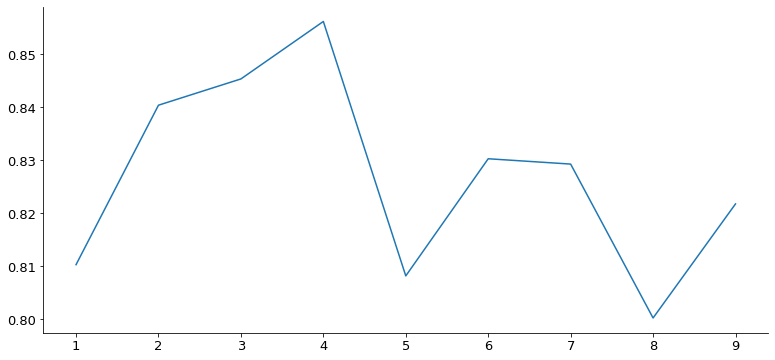

In [32]:
autocorr.plot()




In [ ]:
# AUTOCORRELATION PLOT FOR YEAR PERIODS

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

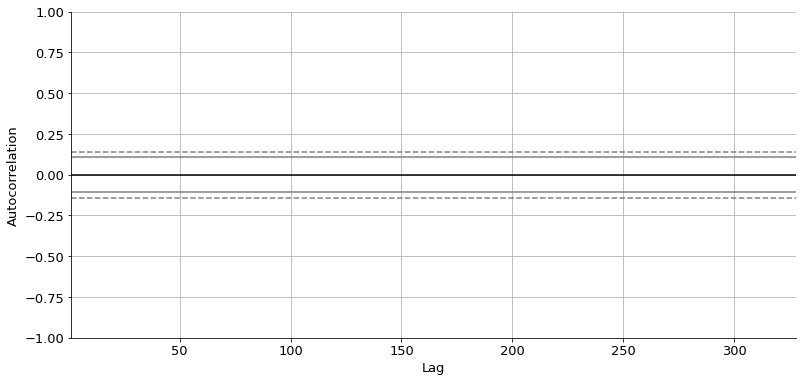

In [33]:
pd.plotting.autocorrelation_plot(y.resample('Y').mean())




<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

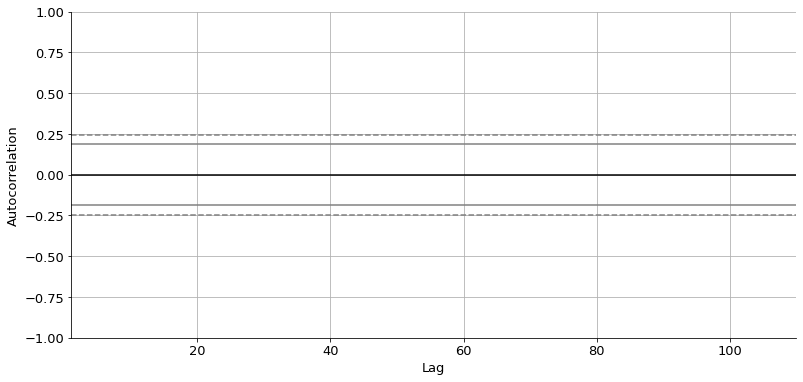

In [34]:

pd.plotting.autocorrelation_plot(y.resample('3Y').mean())



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

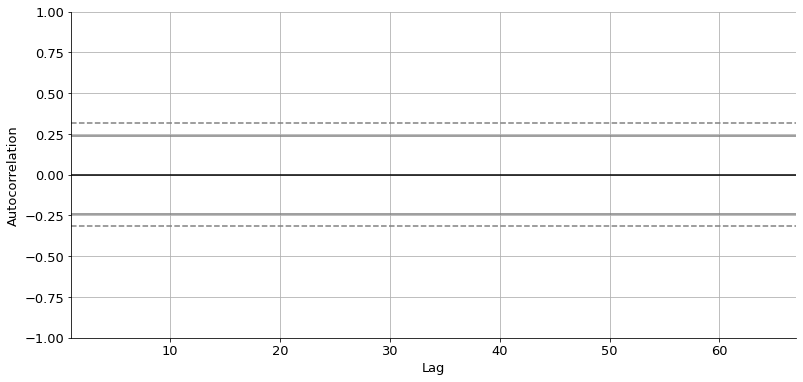

In [35]:
#how correlated is the temp to year
pd.plotting.autocorrelation_plot(y.resample('5Y').mean())


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

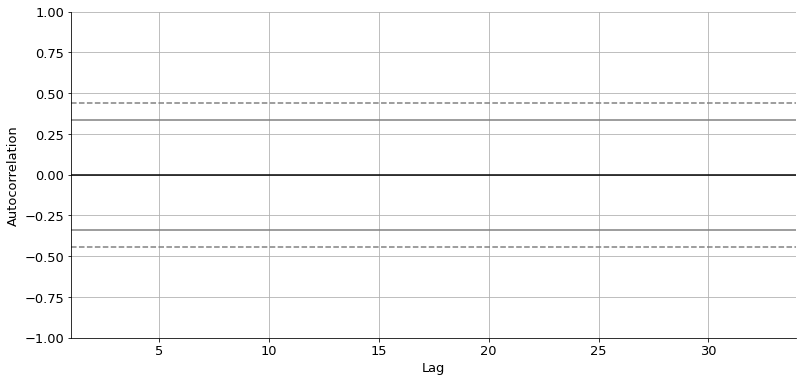

In [36]:
pd.plotting.autocorrelation_plot(y.resample('10Y').mean())

#TAKEAWAYS:
    
#Resamploing by year, 5, 10Y there is a possible correlation in the annual cycle




In [ ]:
#           EXPLORATION TAKEAWAYS
#TEmperatures have maintained fairly consistent behavior throughout the centuries
#Appears to be able to reliably predict at 5 and 10 year intervals
#It is clear that there is an exfcessive amount of data that maybe effecting 
    #the visualization of a trend
#If I had more time I would maybe trim the data down to the last 100 years to see
    #if there could be an improvement in the trendline
    
    
# ===============================================

## Modeling

In [37]:

def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate2[target_var], yhat_df[target_var])), 0)
    return rmse


def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train2[target_var], label='Train', linewidth=1)
    plt.plot(validate2[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    '''
    make a prediction column
    '''
    yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate2.index)

    return yhat_df

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train2[target_var], label='train')
    plt.plot(validate2[target_var], label='validate')
    plt.plot(test2[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()
    
    

In [38]:
# create an empty dataframe to store model type, our avg_temp, and its rmse.
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df




,model_type,target_var,rmse


In [39]:
#Now find the last observed value ------->

#the last observed value: 13.105
temp = train2['avg_temp'][-1:][0]
temp



6.4399999999999995

In [40]:

#predictions based on last observed value
yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate2.index)

yhat_df.head()

,avg_temp
dt,
1844-01-01,6.44
1844-02-01,6.44
1844-03-01,6.44
1844-04-01,6.44
1844-05-01,6.44


avg_temp -- RMSE: 5


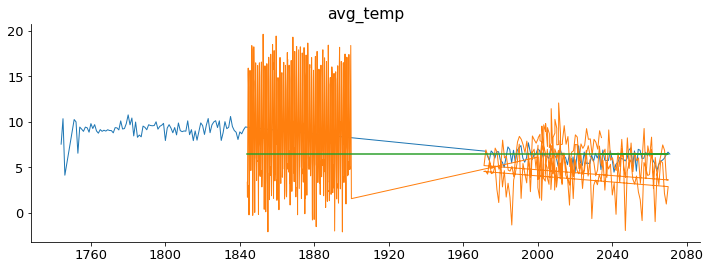

In [41]:
plot_and_eval('avg_temp')


In [42]:
col = 'avg_temp'


eval_df = append_eval_df(model_type ='last_observed_value', 
                             target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,avg_temp,5.0


In [43]:
# =============================================================================
#                   Simple Average
# =============================================================================
# compute simple average/the mean of avergae temperatures
temp = round(train2['avg_temp'].mean(),2)
temp

7.63

In [44]:
#predictions with simple average
yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate2.index)

yhat_df.head()

,avg_temp
dt,
1844-01-01,7.63
1844-02-01,7.63
1844-03-01,7.63
1844-04-01,7.63
1844-05-01,7.63


avg_temp -- RMSE: 5


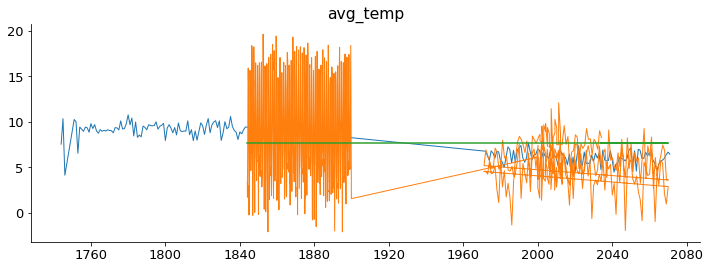

In [45]:

#visualize simple average predictions
plot_and_eval('avg_temp')



In [46]:
#append our simple averages RMSE to our evaluation dataframe
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,avg_temp,5.0
1,simple_average,avg_temp,5.0


In [47]:
# =============================================================================
#                       Moving Average
# =============================================================================
#Let's look at the rolling average of 3 months 
period = 5

temp = round(train2['avg_temp'].rolling(period).mean()[-1],2)
print(temp)

#14.35











6.25


In [48]:
yhat_df = make_predictions()
yhat_df.head(2)


,avg_temp
dt,
1844-01-01,6.25
1844-02-01,6.25


avg_temp -- RMSE: 5


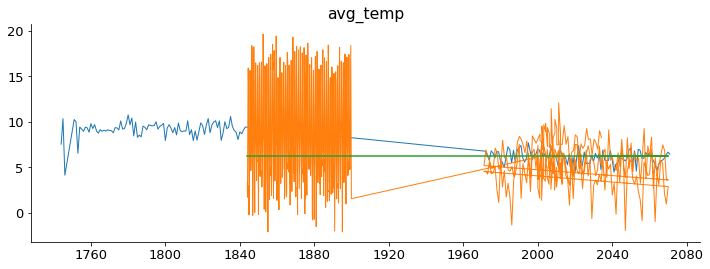

In [49]:
#visualize the rolling average of 3 months
plot_and_eval('avg_temp')


In [50]:
eval_df = append_eval_df(model_type = '5 year_moving_avg', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,5.0
1,simple_average,avg_temp,5.0
2,5 year_moving_avg,avg_temp,5.0


In [51]:
#let's test out , a year, a year and a half, 2 years, and 3 years for moving averages
periods = [5, 10, 15, 20]

for p in periods: 
    temp = round(train2['avg_temp'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'year_moving_avg'
    for col in train2.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)
        

In [52]:
  # so far we have some competing parties, moving along
min_temp_rmse = eval_df[eval_df.target_var=='avg_temp']['rmse'].min()

eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,5.0
1,simple_average,avg_temp,5.0
2,5 year_moving_avg,avg_temp,5.0
3,5year_moving_avg,avg_temp,5.0
4,10year_moving_avg,avg_temp,5.0
5,15year_moving_avg,avg_temp,5.0
6,20year_moving_avg,avg_temp,5.0


In [53]:
#still a four way tie!
eval_df[eval_df.rmse==min_temp_rmse]
 

,model_type,target_var,rmse
0,last_observed_value,avg_temp,5.0
1,simple_average,avg_temp,5.0
2,5 year_moving_avg,avg_temp,5.0
3,5year_moving_avg,avg_temp,5.0
4,10year_moving_avg,avg_temp,5.0
5,15year_moving_avg,avg_temp,5.0
6,20year_moving_avg,avg_temp,5.0


In [54]:
train = df[df['year']=='2010']
validate = df[df['year']=='2011']
test = df[df['year']=='2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()


(0, 3)
(0, 3)
(0, 3)


,avg_temp,avg_temp_uncertainty,year
dt,,,


In [55]:
#our prediction will be a year added to train (2010)
yhat_df = train['avg_temp'] + train['avg_temp'].diff(1).mean()




In [ ]:
#prediction vs actual value
pred = pd.concat([yhat_df, validate["avg_temp"]], axis=0)


